In this experiment, we are going to visualize the uncertainty of a deep neural network by
using dropout as a mean of Bayesian Approximation [[1]](https://arxiv.org/abs/1506.02142).

We are going to use the [monkey species dataset from Kaggle](https://www.kaggle.com/slothkong/10-monkey-species).
If you want to run this notebook, clone it in your Colab, get your Kaggle API key,
upload it on your Colab, download the Kaggle monkey dataset and start cracking.

# Download Dataset from Kaggle

In [ ]:
! pip install -q kaggle
from google.colab import files

This is where you upload your Kaggle API JSON file.
Steps to do that: Go to your Kaggle account and look for API token generation section.
Expire your previous tokens (if you any of them) and then, create a new token. You can
just create a new token without expiring your previous tokens if you wish too.
This will download a `Kaggle.json` file. Upload this file in the following step.

In [ ]:
# Run this cell and press Browse to upload Kaggle.json file
files.upload()

### Download local copy of monkey dataset

In [ ]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d slothkong/10-monkey-species
! mkdir monkey_dataset
! unzip 10-monkey-species.zip -d monkey_dataset

In [ ]:
# Disable eager execution for K.function() with learning_phase to work properly
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

## Clone git repo and get supporting scripts (Only for Colab)

In [ ]:
## If you are running this notebook in Colab, uncomment the following lines
!git clone https://github.com/ArkAung/dropout_bayesian_nn.git
!cp dropout_bayesian_nn/network.py network.py
!cp dropout_bayesian_nn/dataset.py dataset.py
!cp dropout_bayesian_nn/plotting.py plotting.py

# Preparation

In [1]:
from network import Network
from plotting import plot_grid, visualize_probdist
from dataset import Dataset, DatasetType

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IMAGE_SHAPE = (224, 224, 3)
BATCH_SIZE = 32

train_dir = 'monkey_dataset/training/training'
test_dir = 'monkey_dataset/validation/validation'

# The CSV file contains spaces for data fields and column names which we need to remove.
monkey_labels = pd.read_csv("monkey_dataset/monkey_labels.txt")
monkey_labels.columns = [c.strip() for c in monkey_labels.columns]
monkey_labels['Label'] = monkey_labels['Label'].str.strip()
monkey_labels['Common Name'] = monkey_labels['Common Name'].str.strip()

### Plot Training and Testing Data Count Distribution

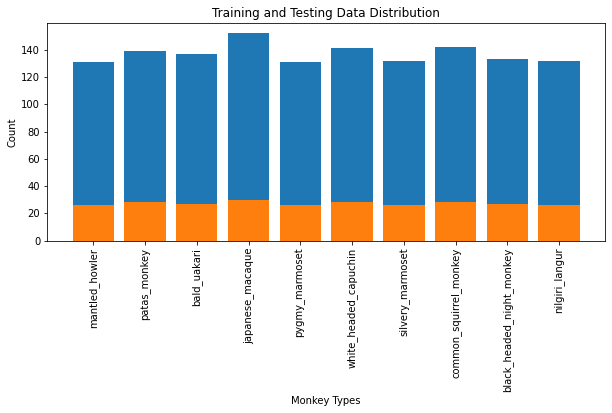

In [3]:
plt.figure(figsize=(10,4))

plt.bar(range(len(monkey_labels['Train Images'])), monkey_labels['Train Images'])
plt.bar(range(len(monkey_labels['Validation Images'])), monkey_labels['Validation Images'])
plt.xticks(range(len(monkey_labels['Common Name'])), monkey_labels['Common Name'], rotation=90)
plt.xlabel('Monkey Types')
plt.ylabel('Count')
plt.title('Training and Testing Data Distribution')
plt.show()

# Visualize Monkeys in the Dataset

In [4]:
# [Class Folder Name]: [Common Name]

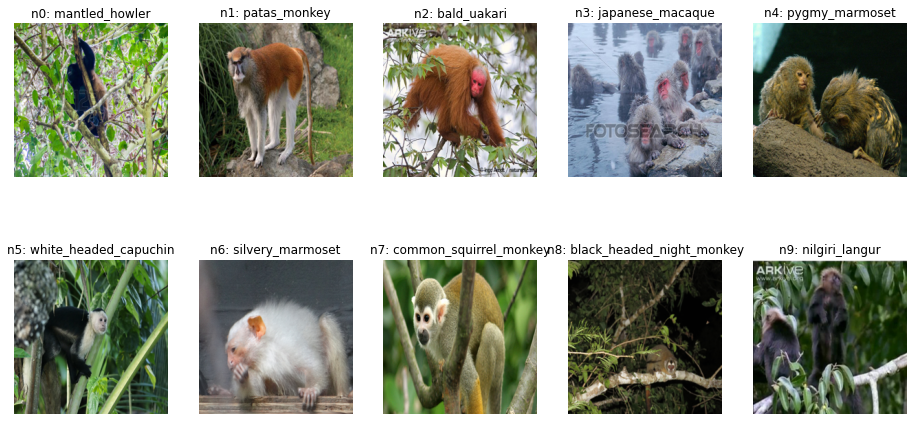

In [5]:
plot_grid(rows=2, cols=5, figsize=(16,8),
          image_root_path=train_dir, labels=monkey_labels, data_shape=IMAGE_SHAPE[:2])

# Training

We want to train some classes of monkeys and see how our model performs for classes of monkeys which it was never trained before (testing out of distribution uncertainty). But this is not as extreme as testing out on completely different looking data samples (like objects, and other animals)

In [6]:
# Selecting classes of monkey to train
class_filter = ['n0', 'n1', 'n2', 'n3', 'n4']
label_mapping = monkey_labels['Common Name'][:5].to_dict() # Get class folder name -> common name mapping by taking the first five rows from dataframe

In [7]:
train_dataset = Dataset(path=train_dir, target_size=IMAGE_SHAPE[:2], dataset_type=DatasetType.TRAIN,
                        batch_size=BATCH_SIZE,
                        class_filter=class_filter,
                        label_mapping=label_mapping)

val_dataset = Dataset(path=train_dir, target_size=IMAGE_SHAPE[:2], dataset_type=DatasetType.VAL,
                      batch_size=BATCH_SIZE,
                      data_generator=train_dataset.data_generator,
                      class_filter=class_filter,
                      label_mapping=label_mapping)

test_dataset = Dataset(path=test_dir, target_size=IMAGE_SHAPE[:2], dataset_type=DatasetType.TEST,
                       batch_size=BATCH_SIZE,
                       class_filter=class_filter,
                       label_mapping=label_mapping)

Found 499 images belonging to 5 classes.
Found 54 images belonging to 5 classes.
Found 137 images belonging to 5 classes.


In [8]:
net = Network(input_shape=IMAGE_SHAPE, dropout_rate=0.2, num_classes=len(class_filter))

In [9]:
net.train_model(train_dataset, val_dataset, epochs=2)

Epoch 1/2
16/15 [==============================] - 37s 2s/step - loss: 1.5925 - accuracy: 0.2846 - val_loss: 1.3405 - val_accuracy: 0.3704
Epoch 2/2
16/15 [==============================] - 35s 2s/step - loss: 1.3576 - accuracy: 0.4589 - val_loss: 1.1698 - val_accuracy: 0.4630


In [11]:
y_prob_preds = net.model.predict(test_dataset.data_iterator)
y_preds = np.argmax(y_prob_preds, axis=1)

label_test = test_dataset.data_iterator.classes

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_test, y_preds))